In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, f_oneway
from datetime import datetime as dt, timedelta
from geopy.distance import vincenty
sns.set_style("whitegrid")
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

//anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Question 1

#### Download the data set

In [2]:
data = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv', parse_dates=['lpep_pickup_datetime', 'Lpep_dropoff_datetime'])

#### Show basic information about the dataset

In [3]:
print('The dataset has {:,} rows and {:,} columns.'.format(data.shape[0], data.shape[1]), '\n')
print('The dataset has following features: \n', list(data.columns), '\n')
print('Overview of the dataset:')
data.head()

The dataset has 1,494,926 rows and 21 columns. 

The dataset has following features: 
 ['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude', 'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge', 'Total_amount', 'Payment_type', 'Trip_type '] 

Overview of the dataset:


,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,...,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,...,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0


# Question 2

#### Histogram of trip distance

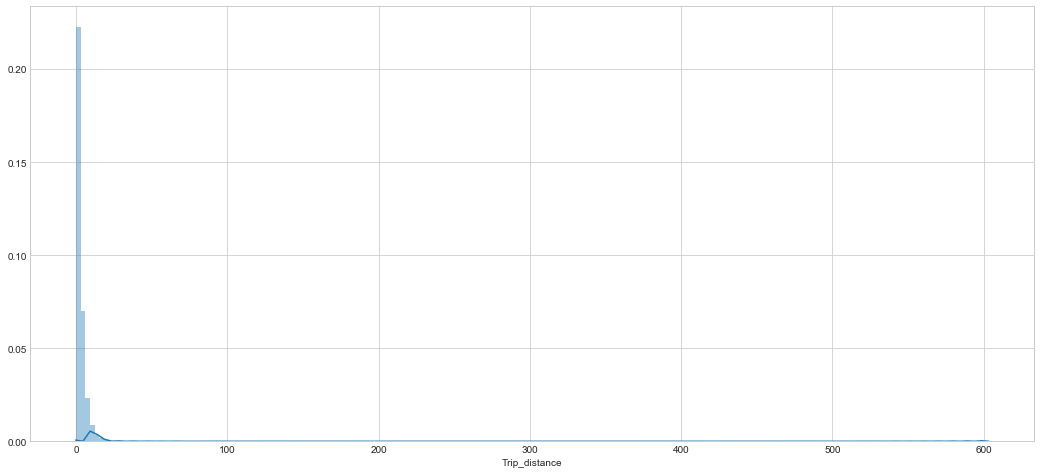

In [4]:
plt.figure(figsize=(18,8))
sns.distplot(data['Trip_distance'], kde=True, bins=200)
plt.show()

We can see from the graph above which does not provide much useful insight. <br>
Now we look at its basic stats and draw another histogram.

In [5]:
data['Trip_distance'].describe()
trip_d = len(data['Trip_distance'].loc[data['Trip_distance'] > 20])
print('The number of trips with distance greater than 45 miles is: {}'.format(trip_d))
print('Which is {:4f}% of the whole dataset.'.format(trip_d/len(data['Trip_distance'])*100))

The number of trips with distance greater than 45 miles is: 3364
Which is 0.225028% of the whole dataset.


Trip distance which is greater than 20 miles will be igonre for better visualization. <br>
The proportion ignored is extremely small so that it will not hurt our understanding of the data.

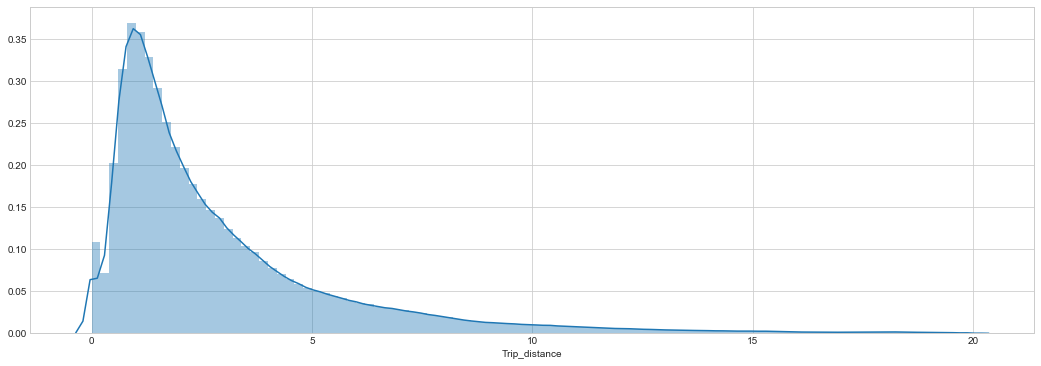

In [6]:
less_20 = data['Trip_distance'].loc[data['Trip_distance'] < 20]

plt.figure(figsize=(18,6))
sns.distplot(less_20, kde=True, bins=100)
plt.show()

### Hypothesis

We observe that this variable has a long tail on the right side so it is reasonable to doubt if this variable is positively skewed. <br>
To test if it is positively skewed, a hypothesis is needed.<br>
We can conduct Kolmogorov-Smirnov test (K-S) and Shapiro-Wilk (S-W) test.<br>
The null hypothesis(H0) is: the data is not skewed, and the alternative hypothesis(H1) is: the data is skewed.<br>
Using confidence level of 95%, if the P-value is less than 0.05, then we will reject the null and accpet alternative which means the data is skewed.

If the data is skewed, log transformation may be needed since our assumption is that data is normally distributed.

In [7]:
kstest(data['Trip_distance'], 'norm')

KstestResult(statistic=0.65223445524177803, pvalue=0.0)

The above is using K-S test to see if the data is skewed. As we can see the p-value is close to 0 which means it reject null hypothesis and accept alternative. <br>
The distribution of this variable is skewed.

# Question 3

### Mean and Median trip distance based on hour of day

In [8]:
mean_hour = data[['Trip_distance', 'lpep_pickup_datetime']].groupby(data['lpep_pickup_datetime'].dt.hour).mean()
median_hour = data[['Trip_distance', 'lpep_pickup_datetime']].groupby(data['lpep_pickup_datetime'].dt.hour).median()
trip_byhour = pd.concat([mean_hour, median_hour], axis=1)
trip_byhour.columns = ['mean', 'median']
trip_byhour

,mean,median
lpep_pickup_datetime,,
0,3.115276,2.20
1,3.017347,2.12
2,3.046176,2.14
3,3.212945,2.20
4,3.526555,2.36
5,4.133474,2.90
6,4.055149,2.84
7,3.284394,2.17
8,3.048450,1.98


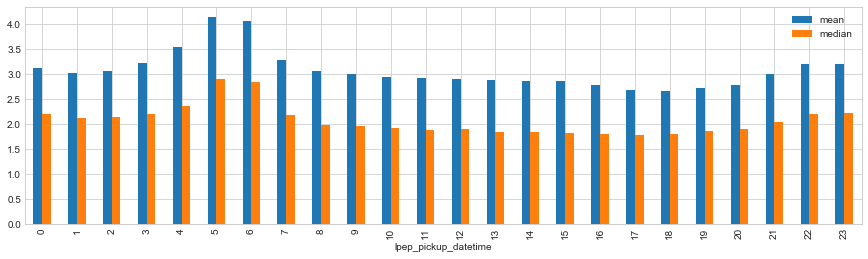

In [9]:
trip_byhour.plot(kind='bar', figsize=(15,4))
plt.show()

Above is the trip distance grouped by hour of day.<br>
As it shown here, long trips mostly happen from 5-7 am, and the rest of time have samilar pattern.

### Trips near Airport

#### The John F Kennedy International Airport (JFK) coordinate is 40.6413° N, 73.7781° W
We will compute the distance from both originate or terminate to the airport and count how many trips are near airport as well as showing the average fare.

Here is to compute the distance using **geopy vincenty distance**. If distance is less than **2** miles, it will be counted as originate or terminate at the airport.

In [10]:
lat, long = 40.6413, -73.7781
pickup_lat, pickup_lon = data['Pickup_latitude'],data['Pickup_longitude']
drop_lat, drop_lon = data['Dropoff_latitude'],data['Dropoff_longitude']

In [11]:
pick_air = []
for a, b in zip(pickup_lat, pickup_lon):
    dis = vincenty((a,b), (lat,long)).miles
    pick_air.append(dis)
    
drop_air = []
for c, d in zip(drop_lat, drop_lon):
    dis = vincenty((c,d), (lat, long)).miles
    drop_air.append(dis)

In [12]:
pick_air, drop_air = pd.Series(pick_air), pd.Series(drop_air)
data['pick_air'], data['drop_air'] = pick_air, drop_air

start_air = np.array(data[['Fare_amount']].loc[data['pick_air'] < 2 ])
end_air   = np.array(data[['Fare_amount']].loc[data['drop_air'] < 2 ])

print('There are {} trips originate from airport have fare below 0 so it will be deleted.'.format((start_air<0).sum()))
print('There are {} trips terminate at airport have fare below 0 so it will be deleted. \n'.format((end_air<0).sum()))

start_air = np.delete(start_air, np.where(start_air < 0)[0])
end_air = np.delete(end_air, np.where(end_air < 0)[0])

print('Trips starting from airport have average {:.2f} fare.'.format(start_air.mean()))
print('Trips ending at aiprot have average {:.2f} fare.'.format(end_air.mean()))

There are 3 trips originate from airport have fare below 0 so it will be deleted.
There are 3 trips terminate at airport have fare below 0 so it will be deleted. 

Trips starting from airport have average 33.26 fare.
Trips ending at aiprot have average 39.97 fare.


#### Distribution of fare where originate or terminate at airport.

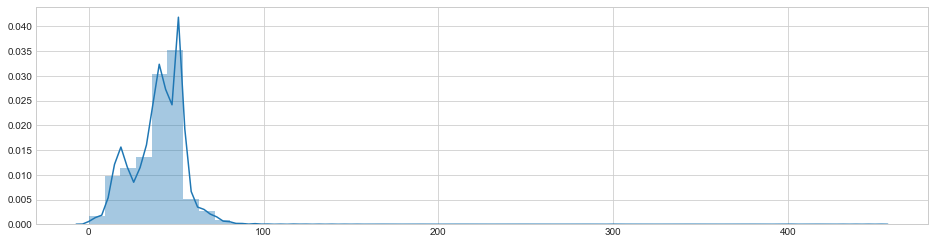

In [13]:
air = np.concatenate((start_air, end_air))
plt.figure(figsize=(16,4))
sns.distplot(air)
plt.show()

#### Another finding: originate and terminate at airport based on hour of day

In [14]:
start_hour = data[['lpep_pickup_datetime']].loc[data['pick_air'] < 2] 
end_hour   = data[['Lpep_dropoff_datetime']].loc[data['drop_air'] < 2 ]

sh = start_hour.groupby(start_hour['lpep_pickup_datetime'].dt.hour).count()
eh = end_hour.groupby(end_hour['Lpep_dropoff_datetime'].dt.hour).count()
seh= pd.concat([sh, eh], axis=1)
seh

,lpep_pickup_datetime,Lpep_dropoff_datetime
0,10,128
1,7,57
2,4,56
3,7,114
4,7,283
5,16,651
6,23,739
7,16,733
8,15,656
9,24,771


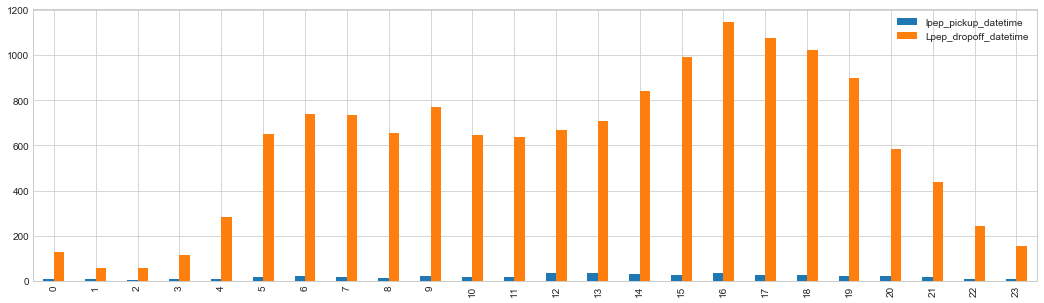

In [15]:
seh.plot(kind='bar', figsize=(18,5))
plt.show()

# Question 4

Here we extract only tip amount is greater than 0.5 since there are too many zero tips. <br>
The reason is that there so many trips having total amount equals to zero, trip distance equals to zero which create infinite numbers while calculating tip amount.<br>

#### Adding variable indicating percentage of Total Amount

In [16]:
tip_data = data.copy()
tip_data = tip_data.loc[tip_data['Tip_amount'] > 0.5]
tip_data['Tip_percent'] = tip_data['Tip_amount'] / tip_data['Total_amount']

In [17]:
tip_var = ['lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'RateCodeID', 'Passenger_count', 'Trip_distance', 
           'Fare_amount', 'Extra', 'MTA_tax', 'Tolls_amount', 'improvement_surcharge', 'Trip_type ', 'Tip_percent']
tip_data = tip_data[tip_var]


tip_data['Trip_duration'] = (tip_data['Lpep_dropoff_datetime'] - tip_data['lpep_pickup_datetime'])
def to_sec(min):
    return min.total_seconds()
tip_data['Trip_duration'] = tip_data['Trip_duration'].apply(to_sec)
tip_data.drop(['lpep_pickup_datetime', 'Lpep_dropoff_datetime'], axis=1, inplace=True)

# create dummy variable for RateCodeId andpayment type and fill NA
rateid = pd.get_dummies(tip_data['RateCodeID'], drop_first=True, prefix='RateID')
tip_data = pd.concat([tip_data, rateid], axis=1)
tip_data.drop(['RateCodeID'], axis=1, inplace=True)
tip_data['Trip_type '] = tip_data['Trip_type '].fillna(value=1)

In [18]:
x, x_test, y, y_test = train_test_split(tip_data.drop(['Tip_percent'], axis=1), tip_data['Tip_percent'])

x_cons = sm.add_constant(x)
line_reg = sm.OLS(y, x_cons).fit()
print(line_reg.summary())

                            OLS Regression Results                            
Dep. Variable:            Tip_percent   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1019.
Date:                Fri, 03 Nov 2017   Prob (F-statistic):               0.00
Time:                        22:51:09   Log-Likelihood:             6.5962e+05
No. Observations:              447726   AIC:                        -1.319e+06
Df Residuals:                  447712   BIC:                        -1.319e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.12

As we can see here that the R-squared is too small to make this regression meaningful, there are severeal reasons.<br>
First of all, the data has not cleaned well, there are too many unusual trips having extrem numbers.
Secondly, tip amount may not be presented effectively. Many tips are very small.<br>
Based on these findings, I would conclude that tip amount is given by random. Customers giving tips are not based fare amount of trip distance. Therefore, I could not find much linear pattern here.

# Question 5 Option A

#### Speed by date of the month

In [19]:
data['Trip_duration'] = (data['Lpep_dropoff_datetime'] - data['lpep_pickup_datetime'])
data['Trip_duration'] = data['Trip_duration'].apply(to_sec)
data['speed'] = data['Trip_distance'] / (data['Trip_duration'] + 0.1) * 3600

In [20]:
def to_weekday(day):
    return day.weekday()
data['day_week'] = data['lpep_pickup_datetime'].apply(to_weekday)
data['day_week'] = data['day_week'] +1

def to_monthday(day):
    return day.day
data['day_month'] = data['lpep_pickup_datetime'].apply(to_monthday)
data[['day_month', 'speed']].groupby(['day_month']).mean().T

day_month,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
speed,18.699541,36.052427,14.790572,20.68003,19.197536,39.530715,25.597709,29.225979,58.050735,44.454676,...,69.096724,22.053775,19.491488,18.777359,29.995324,27.088563,45.649113,51.541058,27.776031,109.641416


The following plot shows the average spped on each day in September

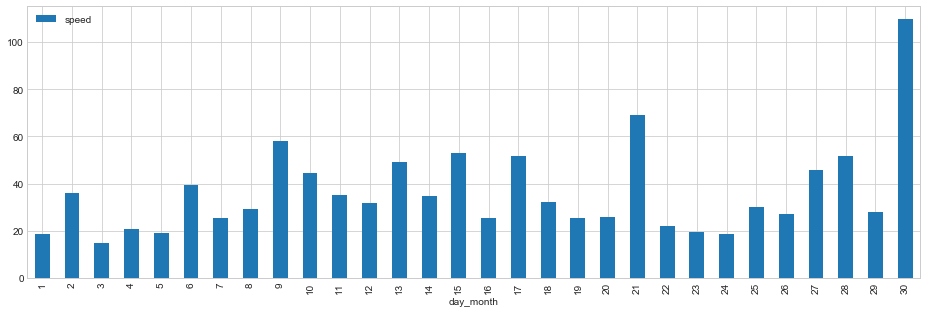

In [21]:
data[['day_month', 'speed']].groupby(['day_month']).mean().plot(kind='bar', figsize=(16,5))
plt.show()

#### Speed by weeks of the month
there are 5 weeks in September

week           1          2          3          4          5
speed  21.545474  37.698545  38.055538  30.021428  58.744933


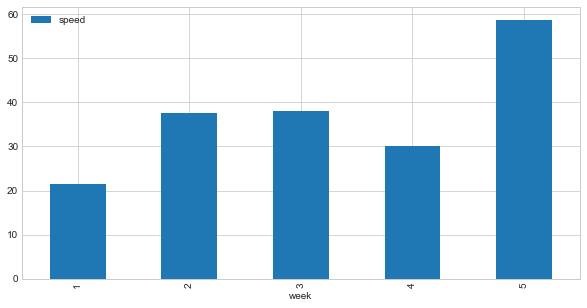

In [22]:
def weeks(day):
    if day > 26:
        return 5
    elif (day > 19) & (day < 27):
        return 4
    elif (day > 12) & (day < 20):
        return 3
    elif (day > 5) & (day < 13):
        return 2
    else:
        return 1
data['week'] = data['day_month'].apply(weeks)
print(data[['week', 'speed']].groupby(['week']).mean().T)
data[['week', 'speed']].groupby(['week']).mean().plot(kind='bar', figsize=(10,5))
plt.show()

In [23]:
week_1 = data['speed'].loc[data['week']==1]
week_2 = data['speed'].loc[data['week']==2]
week_3 = data['speed'].loc[data['week']==3]
week_4 = data['speed'].loc[data['week']==4]
week_5 = data['speed'].loc[data['week']==5]

f_oneway(week_1, week_2, week_3, week_4, week_5)

F_onewayResult(statistic=2.0241788041310333, pvalue=0.088099535002236565)

To determine if the average trip speeds are maerially the same in all weeks of September, I use ANOVA test.<br>
As we can see the P-value is greater than 0.05 which means that the mean for each group is not significantly different from the others.

#### Speed by day of week for the month
Here is to calculate Mon-Sun speed regardless of which week

In [24]:
data[['day_week', 'speed']].groupby(['day_week']).mean()

,speed
day_week,
1,45.420805
2,30.104382
3,50.659190
4,33.436784
5,29.613360
6,26.113824
7,39.937959


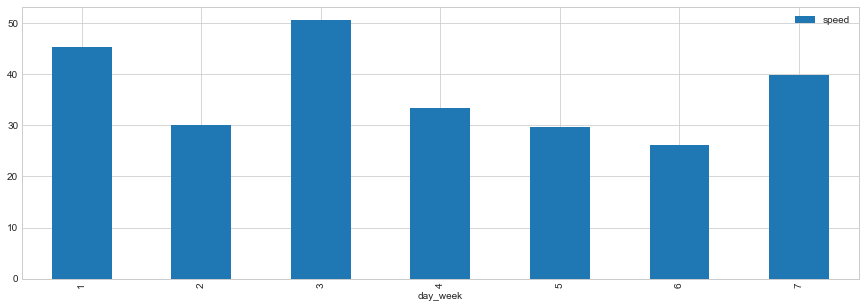

In [25]:
data[['day_week', 'speed']].groupby(['day_week']).mean().plot(kind='bar', figsize=(15,5))
plt.show()

In [26]:
dayweek_1 = data['speed'].loc[data['day_week']==1]
dayweek_2 = data['speed'].loc[data['day_week']==2]
dayweek_3 = data['speed'].loc[data['day_week']==3]
dayweek_4 = data['speed'].loc[data['day_week']==4]
dayweek_5 = data['speed'].loc[data['day_week']==5]
dayweek_6 = data['speed'].loc[data['day_week']==6]
dayweek_7 = data['speed'].loc[data['day_week']==7]

f_oneway(dayweek_1, dayweek_2, dayweek_3, dayweek_4, dayweek_5, dayweek_6, dayweek_7)

F_onewayResult(statistic=0.90629218971781556, pvalue=0.48901210015527152)

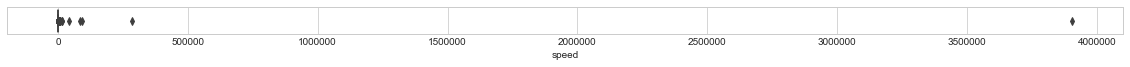

count    4.660800e+04
mean     1.096414e+02
std      1.815239e+04
min      0.000000e+00
25%      8.801956e+00
50%      1.112202e+01
75%      1.417036e+01
max      3.906000e+06
Name: speed, dtype: float64

In [27]:
plt.figure(1, figsize=(20,0.5))
sns.boxplot(x=data['speed'].loc[data['day_month'] ==30], orient='h')
plt.show()
data['speed'].loc[data['day_month'] ==30].describe()

### Replace outliers to mean of speed
As the discover to the data, I found there are some speeds are unbelievablely high such as over 200 miles per hour. Thus I will replace speed over 150 to the mean speed. And test its ditribution again.

In [28]:
data['speed'].loc[data['speed'] > 150] = data['speed'].mean()

#### Speed by day of month

In [29]:
data[['day_month', 'speed']].groupby(['day_month']).mean().T

day_month,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
speed,12.744787,12.792451,12.519182,12.946911,14.089274,14.524076,14.678217,12.419023,11.895949,11.234747,...,12.643273,12.560347,13.414546,13.568477,12.822723,13.066746,13.855641,13.013409,12.35447,12.106771


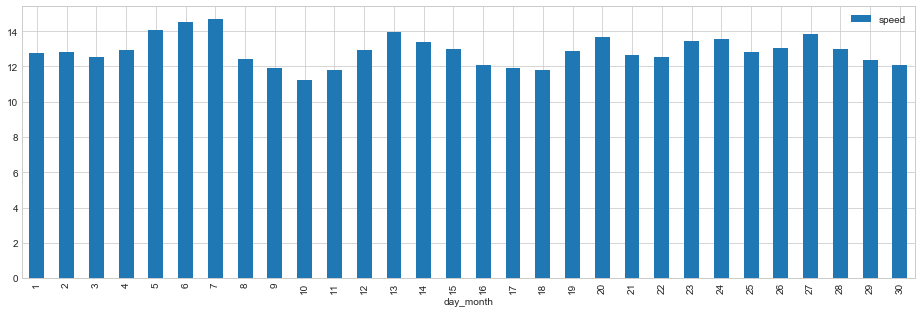

In [30]:
data[['day_month', 'speed']].groupby(['day_month']).mean().plot(kind='bar', figsize=(16,5))
plt.show()

#### Speed by weeks of month

In [31]:
data[['week', 'speed']].groupby(['week']).mean().T

week,1,2,3,4,5
speed,13.074442,12.746674,12.702348,13.11425,12.880626


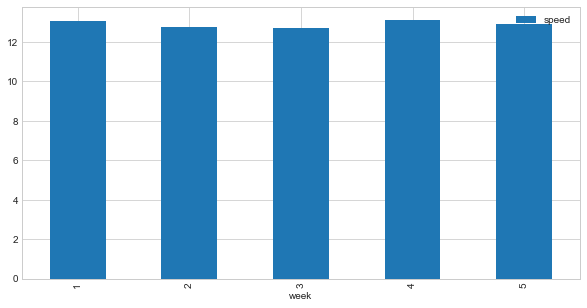

In [32]:
data[['week', 'speed']].groupby(['week']).mean().plot(kind='bar', figsize=(10,5))
plt.show()

In [33]:
week_1 = data['speed'].loc[data['week']==1]
week_2 = data['speed'].loc[data['week']==2]
week_3 = data['speed'].loc[data['week']==3]
week_4 = data['speed'].loc[data['week']==4]
week_5 = data['speed'].loc[data['week']==5]

f_oneway(week_1, week_2, week_3, week_4, week_5)

F_onewayResult(statistic=282.61032621475465, pvalue=2.3616329533010673e-243)

Here I use ANOVA again and the P-value is very small which indicates that the at least one of group mean is significantly different from the others.

#### Speed by day of week

In [34]:
data[['day_week', 'speed']].groupby(['day_week']).mean()

,speed
day_week,
1,13.433501
2,12.611056
3,12.430550
4,12.224180
5,12.325709
6,13.218812
7,13.981455


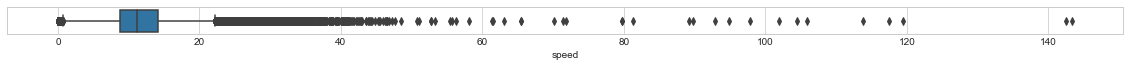

count    46608.000000
mean        12.106771
std          5.860277
min          0.000000
25%          8.801956
50%         11.122023
75%         14.170357
max        143.426295
Name: speed, dtype: float64

In [35]:
plt.figure(1, figsize=(20,0.5))
sns.boxplot(x=data['speed'].loc[data['day_month'] ==30], orient='h')
plt.show()
data['speed'].loc[data['day_month'] ==30].describe()

# Conclusion

For this data set, I think there are a lot of pre-processing could be done before build a model because the data has so many weird and extrem values.<br>
A lot of feature engineerings could be done so that I could have more insight from data. I would exam each feature carefully and revise them accordingly to improve its effeciency of information delievery.

If I could have more time, I will do feature engineering and split data set into train and test and then build a linear regression using LinearRegression(). I may also apply log transform to the data set.